<a href="https://colab.research.google.com/github/yudumpacin/NLPStudyNotes/blob/main/TextClassification_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Turkish Text Classification with Deep Learning

In [51]:
import tensorflow as tf

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [53]:
from tensorflow import keras

In [115]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import (
    Dense,Input,MaxPooling1D,Conv1D, GlobalMaxPool1D, GlobalMaxPooling1D,GlobalAveragePooling1D ,Embedding,Dense, Input
)
from keras.models import Model
from keras.layers import Flatten
from keras.layers import  GRU
from keras.layers import LSTM, Bidirectional
from keras.layers import Dropout

# Getting the Kaggle Data

Data source is A Benchmark Data for Turkish Text Categorization on Kaggle https://www.kaggle.com/datasets/savasy/ttc4900

In [55]:
!pip install -q kaggle

In [56]:
!mkdir -p ~/.kaggle

In [57]:
!cp kaggle.json ~/.kaggle

In [58]:
!chmod 600 /root/.kaggle/kaggle.json

In [59]:
!kaggle datasets download -d savasy/ttc4900

ttc4900.zip: Skipping, found more recently modified local copy (use --force to force download)


In [60]:
!unzip /content/ttc4900

Archive:  /content/ttc4900.zip
replace 7allV03.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [61]:
df = pd.read_csv("/content/7allV03.csv")

In [62]:
df.head()

,category,text
0,siyaset,3 milyon ile ön seçim vaadi mhp nin 10 olağan...
1,siyaset,mesut_yılmaz yüce_divan da ceza alabilirdi pr...
2,siyaset,disko lar kaldırılıyor başbakan_yardımcısı ar...
3,siyaset,sarıgül anayasa_mahkemesi ne gidiyor mustafa_...
4,siyaset,erdoğan idamın bir haklılık sebebi var demek ...


In [63]:
df.shape

(4900, 2)

In [64]:
df.category.value_counts()

siyaset       700
dunya         700
ekonomi       700
kultur        700
saglik        700
spor          700
teknoloji     700
Name: category, dtype: int64

In [65]:
len_of_labels = len(np.unique(df.category))

In [66]:
len_of_labels

7

In [67]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re

stop_words = set(stopwords.words('turkish'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [68]:
def preprocess_for_training(text_data):
  text_data = re.sub("[^a-zA-ZğüşöçıİĞÜŞÖÇ0-9.,;:!?'\" ]"," ",text_data)
  text_data = ' '.join([word for word in text_data.split() if word not in stop_words])
  return text_data

In [69]:
df["text"]= df["text"].apply(preprocess_for_training)

In [70]:
def preprocess_for_analysis(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join([word for word in text.split() if len(word)>1])
    return text

In [71]:
df["preprocessed"]= df["text"].apply(preprocess_for_analysis)

In [72]:
for i in df.category.value_counts().index:
  print(i)

siyaset 
dunya 
ekonomi 
kultur 
saglik 
spor 
teknoloji 


In [73]:
from collections import Counter
for i in df.category.value_counts().index:
  data = df[df.category==i]["preprocessed"]
  word_count = Counter(" ".join(data).split())
  most_common= word_count.most_common(10)
  print("Most common words in",i," :", most_common)


Most common words in siyaset   : [('bir', 4613), ('türkiye', 1491), ('nin', 1357), ('ın', 1108), ('başbakan', 1082), ('erdoğan', 963), ('olarak', 944), ('chp', 920), ('dedi', 907), ('genel', 783)]
Most common words in dunya   : [('bir', 1913), ('nin', 1010), ('israil', 795), ('türkiye', 694), ('suriye', 665), ('ın', 649), ('in', 605), ('nın', 574), ('olarak', 469), ('abd', 415)]
Most common words in ekonomi   : [('bir', 2845), ('türkiye', 1716), ('yüzde', 1622), ('milyon', 1096), ('nin', 1073), ('olarak', 929), ('bin', 861), ('milyar', 764), ('göre', 639), ('olan', 634)]
Most common words in kultur   : [('bir', 3189), ('in', 744), ('ın', 696), ('olan', 662), ('film', 642), ('nin', 624), ('olarak', 622), ('istanbul', 613), ('ilk', 556), ('türkiye', 549)]
Most common words in saglik   : [('bir', 3378), ('dr', 1152), ('olarak', 1005), ('olan', 836), ('olduğunu', 820), ('sağlık', 667), ('kalp', 593), ('tedavi', 570), ('önemli', 533), ('dedi', 480)]
Most common words in spor   : [('bir', 19

In [74]:
target = pd.get_dummies(df.category)

In [75]:
target

,dunya,ekonomi,kultur,saglik,siyaset,spor,teknoloji
0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...
4895,0,0,0,0,0,0,1
4896,0,0,0,0,0,0,1
4897,0,0,0,0,0,0,1
4898,0,0,0,0,0,0,1


In [76]:
target.shape

(4900, 7)

In [77]:
X_train,X_test,y_train,y_test = train_test_split(df["text"],target, random_state=0,test_size=0.3)

In [78]:
X_train.shape

(3430,)

In [79]:
y_train.shape

(3430, 7)

In [80]:
max_num_words = max([len(x.split()) for x in df["text"]])
max_num_words

2241

In [81]:
max_vocab_size = 20000
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [82]:
X_train[0][0:20]

'3 milyon ön seçim va'

In [83]:
sequences_train[0][0:20]

[1145,
 4375,
 1201,
 8257,
 1145,
 5,
 1202,
 8258,
 11975,
 4859,
 11976,
 10121,
 4375,
 1201,
 2397,
 5734,
 1346,
 4376,
 1145,
 133]

In [84]:
word2idx = tokenizer.word_index
V = len(word2idx)
print("Total number of unique tokens %s" % V)

Total number of unique tokens 89963


In [85]:
data_train = pad_sequences(sequences_train)
print(data_train.shape)

(3430, 1620)


In [86]:
data_train[0]

array([  0,   0,   0, ..., 116, 325, 554], dtype=int32)

In [87]:
data_test = pad_sequences(sequences_test, maxlen=data_train.shape[1])

# CNN

In [88]:
D=32#embedding vector dimension constant

In [117]:

i = Input(shape=(data_train.shape[1],))

x = Embedding(V + 1, D)(i)

x = Conv1D(32, 4, activation='relu')(x)
x = MaxPooling1D(4)(x)

x = Conv1D(64, 4, activation='relu')(x)
x = MaxPooling1D(4)(x)

x = Conv1D(128, 4, activation='relu')(x)
x = MaxPooling1D(4)(x)

x = Flatten()(x)
x = Dense(y_train.shape[1], activation='softmax')(x)

model_cnn = Model(inputs=i, outputs=x)

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [90]:
history_cnn = model_cnn.fit(x=data_train,y=y_train,epochs=10,validation_data=(data_test,y_test))

Epoch 1/10
108/108 [==============================] - 20s 174ms/step - loss: 1.8869 - accuracy: 0.2064 - val_loss: 1.7431 - val_accuracy: 0.2524
Epoch 2/10
108/108 [==============================] - 16s 152ms/step - loss: 1.4185 - accuracy: 0.4239 - val_loss: 1.2891 - val_accuracy: 0.4578
Epoch 3/10
108/108 [==============================] - 16s 152ms/step - loss: 0.8659 - accuracy: 0.6332 - val_loss: 1.4884 - val_accuracy: 0.5088
Epoch 4/10
108/108 [==============================] - 16s 150ms/step - loss: 0.4792 - accuracy: 0.8222 - val_loss: 1.7669 - val_accuracy: 0.5524
Epoch 5/10
108/108 [==============================] - 16s 151ms/step - loss: 0.3431 - accuracy: 0.8834 - val_loss: 2.0869 - val_accuracy: 0.5673
Epoch 6/10
108/108 [==============================] - 18s 167ms/step - loss: 0.2022 - accuracy: 0.9347 - val_loss: 2.3425 - val_accuracy: 0.5830
Epoch 7/10
108/108 [==============================] - 16s 152ms/step - loss: 0.1386 - accuracy: 0.9633 - val_loss: 2.6978 - val_ac

In [91]:
def plot_results(r):

  plt.plot(r.history['loss'],label='Loss')
  plt.plot(r.history['val_loss'], label='Validation Loss')
  plt.legend()
  plt.show()

  plt.plot(r.history['accuracy'],label='Accuracy')
  plt.plot(r.history['val_accuracy'], label='Val Accuracy Loss')
  plt.legend()
  plt.show()

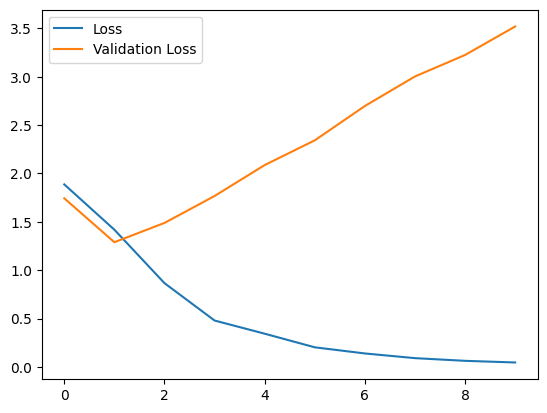

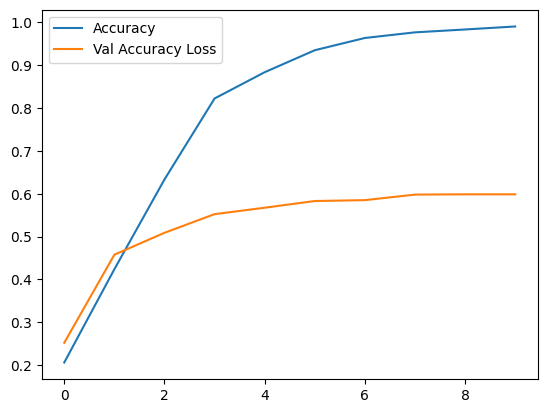

In [92]:
plot_results(history_cnn)

## CNN with Dropout to prevent overfitting

In [ ]:

i = Input(shape=(data_train.shape[1],))

x = Embedding(V + 1, D)(i)
x = Conv1D(64, 4, activation='relu')(x)
x = MaxPooling1D(3)(x)

x = Conv1D(128, 4, activation='relu')(x)
x = MaxPooling1D(3)(x)

x = Conv1D(256, 4, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)

x = GlobalAveragePooling1D()(x)
x = Dense(y_train.shape[1], activation='softmax')(x)

model_cnn_dropout = Model(inputs=i, outputs=x)

model_cnn_dropout.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_cnn_dropout = model_cnn_dropout.fit(x=data_train,y=y_train,epochs=10,validation_data=(data_test,y_test))

The second CNN model's loss is increasing, so i stopped the training.



```
Epoch 1/10
108/108 [==============================] - 156s 490ms/step - loss: 1.8025 - accuracy: 0.2268 - val_loss: 1.5552 - val_accuracy: 0.3340
Epoch 2/10
108/108 [==============================] - 45s 414ms/step - loss: 1.3806 - accuracy: 0.3997 - val_loss: 1.3674 - val_accuracy: 0.4265
Epoch 3/10
108/108 [==============================] - 40s 374ms/step - loss: 1.0547 - accuracy: 0.5332 - val_loss: 1.3171 - val_accuracy: 0.5034
Epoch 4/10
108/108 [==============================] - 46s 429ms/step - loss: 0.7775 - accuracy: 0.6767 - val_loss: 1.4920 - val_accuracy: 0.5020
Epoch 5/10
108/108 [==============================] - 40s 374ms/step - loss: 0.5750 - accuracy: 0.7659 - val_loss: 1.7025 - val_accuracy: 0.5585
Epoch 6/10
 33/108 [========>.....................] - ETA: 27s - loss: 0.4388 - accuracy: 0.8352
```



# LSTM

In [95]:
i = Input(shape = (data_train.shape[1],))
x = Embedding(V+1,D)(i)

x = LSTM(15, return_sequences=True)(x)
x= GlobalMaxPool1D()(x)


x= Dense(y_train.shape[1],activation='softmax')(x)

model_lstm = Model(i,x)

In [96]:
model_lstm.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [97]:
history_lstm = model_lstm.fit(x=data_train,y=y_train,epochs=10,validation_data=(data_test,y_test))

Epoch 1/10
108/108 [==============================] - 116s 1s/step - loss: 1.8908 - accuracy: 0.3085 - val_loss: 1.7366 - val_accuracy: 0.3367
Epoch 2/10
108/108 [==============================] - 123s 1s/step - loss: 1.4969 - accuracy: 0.4478 - val_loss: 1.3309 - val_accuracy: 0.5449
Epoch 3/10
108/108 [==============================] - 113s 1s/step - loss: 1.0810 - accuracy: 0.7222 - val_loss: 1.0608 - val_accuracy: 0.7456
Epoch 4/10
108/108 [==============================] - 98s 905ms/step - loss: 0.7981 - accuracy: 0.8475 - val_loss: 0.8730 - val_accuracy: 0.7946
Epoch 5/10
108/108 [==============================] - 96s 886ms/step - loss: 0.5946 - accuracy: 0.8985 - val_loss: 0.7270 - val_accuracy: 0.8299
Epoch 6/10
108/108 [==============================] - 96s 890ms/step - loss: 0.4407 - accuracy: 0.9417 - val_loss: 0.6592 - val_accuracy: 0.8367
Epoch 7/10
108/108 [==============================] - 96s 891ms/step - loss: 0.3431 - accuracy: 0.9571 - val_loss: 0.5807 - val_accuracy

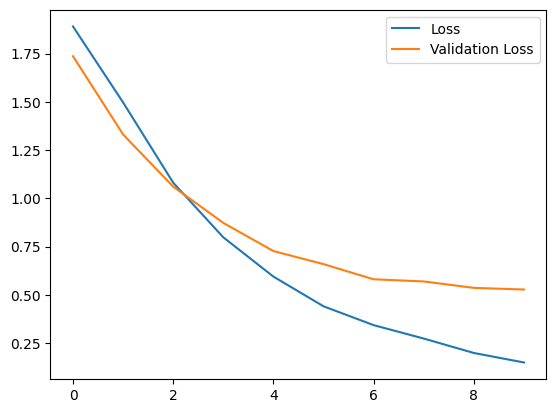

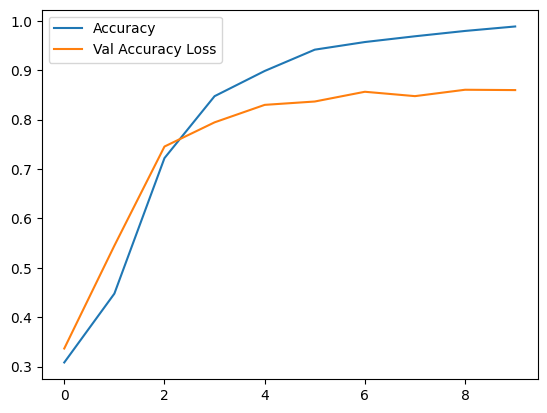

In [98]:
plot_results(history_lstm)

#GRU

In [99]:
i = Input(shape = (data_train.shape[1],))
x = Embedding(V+1,D)(i)

x = GRU(15, return_sequences=True)(x)
x= GlobalMaxPool1D()(x)


x= Dense(y_train.shape[1],activation='softmax')(x)

model_gru = Model(i,x)

In [100]:
model_gru.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [101]:
history_gru = model_gru.fit(x=data_train,y=y_train,epochs=10,validation_data=(data_test,y_test))

Epoch 1/10
108/108 [==============================] - 107s 959ms/step - loss: 1.8978 - accuracy: 0.3883 - val_loss: 1.7962 - val_accuracy: 0.5476
Epoch 2/10
108/108 [==============================] - 105s 970ms/step - loss: 1.4739 - accuracy: 0.6362 - val_loss: 1.2324 - val_accuracy: 0.6599
Epoch 3/10
108/108 [==============================] - 99s 921ms/step - loss: 0.9532 - accuracy: 0.7991 - val_loss: 0.9032 - val_accuracy: 0.7980
Epoch 4/10
108/108 [==============================] - 100s 926ms/step - loss: 0.6229 - accuracy: 0.9093 - val_loss: 0.7046 - val_accuracy: 0.8551
Epoch 5/10
108/108 [==============================] - 100s 924ms/step - loss: 0.4088 - accuracy: 0.9598 - val_loss: 0.6027 - val_accuracy: 0.8537
Epoch 6/10
108/108 [==============================] - 101s 935ms/step - loss: 0.2808 - accuracy: 0.9746 - val_loss: 0.5772 - val_accuracy: 0.8408
Epoch 7/10
108/108 [==============================] - 100s 929ms/step - loss: 0.1966 - accuracy: 0.9863 - val_loss: 0.5265 - 

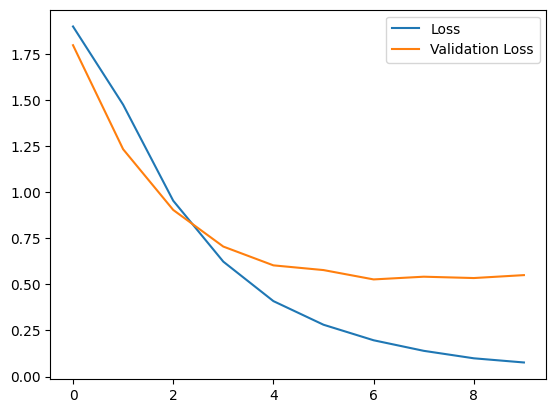

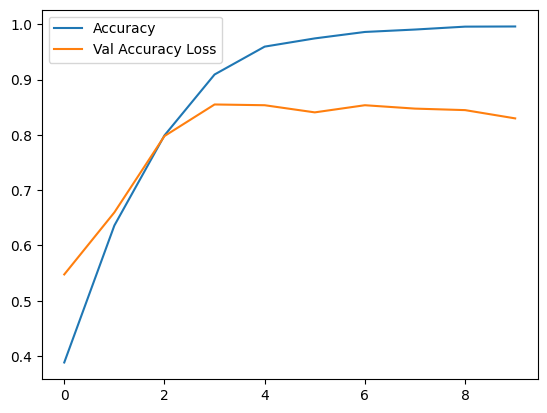

In [102]:
plot_results(history_gru)

#BILSTM

In [103]:
i = Input(shape = (data_train.shape[1],))
x = Embedding(V+1,D)(i)

x = Bidirectional(LSTM(15, return_sequences=True))(x)
x= GlobalMaxPool1D()(x)


x= Dense(y_train.shape[1],activation='softmax')(x)

model_bilstm = Model(i,x)


In [104]:
model_bilstm.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

history_bilstm = model_bilstm.fit(x=data_train,y=y_train,epochs=10,validation_data=(data_test,y_test))

Epoch 1/10
108/108 [==============================] - 186s 2s/step - loss: 1.8852 - accuracy: 0.3172 - val_loss: 1.6915 - val_accuracy: 0.3721
Epoch 2/10
108/108 [==============================] - 180s 2s/step - loss: 1.5594 - accuracy: 0.4886 - val_loss: 1.2621 - val_accuracy: 0.7000
Epoch 3/10
108/108 [==============================] - 180s 2s/step - loss: 0.9587 - accuracy: 0.8394 - val_loss: 0.8804 - val_accuracy: 0.7959
Epoch 4/10
108/108 [==============================] - 180s 2s/step - loss: 0.5676 - accuracy: 0.9023 - val_loss: 0.6920 - val_accuracy: 0.8150
Epoch 5/10
108/108 [==============================] - 181s 2s/step - loss: 0.3351 - accuracy: 0.9394 - val_loss: 0.7106 - val_accuracy: 0.7626
Epoch 6/10
108/108 [==============================] - 179s 2s/step - loss: 0.3166 - accuracy: 0.9373 - val_loss: 0.5050 - val_accuracy: 0.8497
Epoch 7/10
108/108 [==============================] - 179s 2s/step - loss: 0.1540 - accuracy: 0.9796 - val_loss: 0.5033 - val_accuracy: 0.8422

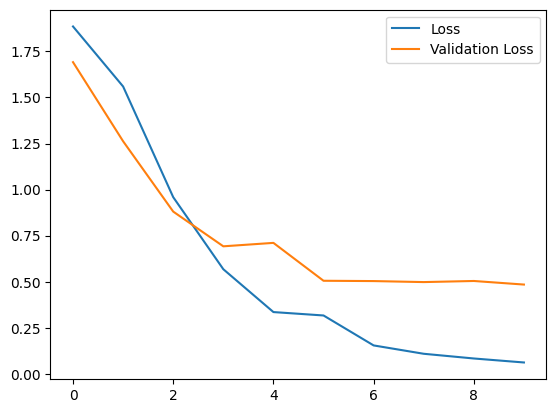

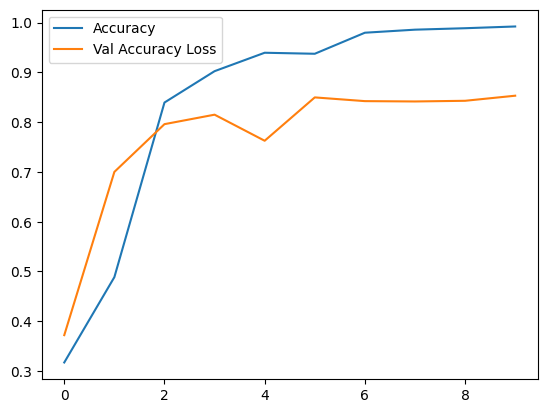

In [125]:
plot_results(history_bilstm)

In [151]:
X_test.iloc[0]

'kanseri önlemek yerine arttırıyorlar dna sarmalını keşfeden nobel ödüllü ünlü biyolog james watson antioksidan hapları ortaya çıkmasını engelledikleri kanserlerden fazla kansere yol açmış olabilir şeklinde açıklama yaptı watson önceki açıklamalarının aksine antioksidan içeren gıdaların haplarını tüketmenin kansere yol açtığını iddia etti ünlü biyolog radyasyon kemoterapi tedavilerinin kanser hücrelerini öldürerek vücutta oksijen açığa çıkarttığını söylüyor kanser tedavisi olan bir hastanın hapları alması terapilerin düzgün çalışmasını engelliyor hayatını kanser mücadeleye adayan watson son dönemde ortaya çıkan birçok araştırma ileri seviyede kanserlerin bir türlü tedavi edilememesinde vücuttaki antioksidan fazlalığının etkisini gösteriyor diyor açıklamaların ardından ingiltere kanser araştırma enstitüsü profesörü olan nick jones antioksidan özelliği bulunan içeriğin sağlıklı bireylerde kanseri önlemede etkisiz olduklarını hatta kişilerde kanser riskini olsa artırdığını belirterek wats

In [133]:
y_test.head()

,dunya,ekonomi,kultur,saglik,siyaset,spor,teknoloji
3301,0,0,0,1,0,0,0
1141,1,0,0,0,0,0,0
4412,0,0,0,0,0,0,1
3083,0,0,0,1,0,0,0
2518,0,0,1,0,0,0,0


Get the inverse of get_dmmies

In [132]:
pd.from_dummies(y_test).rename(columns={'': 'category'}).head()

,category
0,saglik
1,dunya
2,teknoloji
3,saglik
4,kultur


In [172]:
cats = ["dünya","ekonomi",	"kultur"	,"saglik"	,"siyaset",	"spor"	,"teknoloji"]
def model_predict(text, model):
    text = preprocess_for_training(text)
    sequences_test = tokenizer.texts_to_sequences([text])
    data_test = pad_sequences(sequences_test, maxlen=data_train.shape[1])
    predicted = model.predict(data_test)
    predicted_category = predicted.argmax(axis=1)[0]
    probability = predicted[0][predicted_category]
    category = cats[predicted_category]
    return category, probability



In [159]:
models = {"CNN Model": model_cnn,"LSTM Model": model_lstm,"GRU Model":model_gru,"BILSTM Model":model_bilstm}

In [173]:
for name, model in models.items():
  print("-------------",name,"-------------------")
  #This is a test data, category should be "sağlık"

  text = """kanseri önlemek yerine arttırıyorlar dna sarmalını keşfeden nobel ödüllü ünlü biyolog james watson antioksidan hapları ortaya çıkmasını engelledikleri kanserlerden fazla kansere yol açmış olabilir şeklinde açıklama yaptı watson önceki açıklamalarının aksine antioksidan içeren gıdaların haplarını tüketmenin kansere yol açtığını iddia etti ünlü biyolog radyasyon kemoterapi tedavilerinin kanser hücrelerini öldürerek vücutta oksijen açığa çıkarttığını söylüyor kanser tedavisi olan bir hastanın hapları alması terapilerin düzgün çalışmasını engelliyor hayatını kanser mücadeleye adayan watson son dönemde ortaya çıkan birçok araştırma ileri seviyede kanserlerin bir türlü tedavi edilememesinde vücuttaki antioksidan fazlalığının etkisini gösteriyor """
  pred,prob = model_predict(text,model)
  print(pred, prob)

------------- CNN Model -------------------
1/1 [==============================] - 0s 39ms/step
teknoloji 0.14754708
------------- LSTM Model -------------------
1/1 [==============================] - 0s 169ms/step
saglik 0.9221138
------------- GRU Model -------------------
1/1 [==============================] - 0s 174ms/step
saglik 0.83459574
------------- BILSTM Model -------------------
1/1 [==============================] - 0s 210ms/step
saglik 0.9694067


In [174]:
for name, model in models.items():
  print("-------------",name,"-------------------")
  #This is a Turkish text from a news website in "Ekonomi" category
  text = """Milyonlarca memur ve emekli maaş zammının yüzde 49.25 olarak belirlenmesinin ardından maaş farklarını beklemeye başladı. Memur ve memur emeklileri,
  zamlı maaşlarını ve enflasyon farkları 15 Ocak'tan itibaren alacak.
  """
  pred = model_predict(text,model)
  print(pred,prob)

------------- CNN Model -------------------
1/1 [==============================] - 0s 50ms/step
('teknoloji', 0.14731637) 0.9694067
------------- LSTM Model -------------------
1/1 [==============================] - 0s 156ms/step
('ekonomi', 0.61638325) 0.9694067
------------- GRU Model -------------------
1/1 [==============================] - 0s 162ms/step
('ekonomi', 0.5802297) 0.9694067
------------- BILSTM Model -------------------
1/1 [==============================] - 0s 242ms/step
('siyaset', 0.3148235) 0.9694067


LSTM(val_accuracy, 0.8299) and GRU (val_accuracy, 0.8599) Models have highest val accuracy for 10 epochs, increasing epochs can increase the accuracy higher for these models.